In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Load and transform the dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df = pd.read_csv(url, header=None, names=columns)

df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])
df

,id,diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# Training and testing sets
I use the splitting method from scikit-learn which we used a lot in the "Principles of Machine Learning" course.

In [5]:
X = df.drop(['id', 'diagnosis'], axis=1).values
y = df['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implementation of the Naive Bayes classifier

According to ChatGPT the "Gaussian Naive Bayes" classifier is the most suitable for continuous data like the breast cancer dataset.

The main idea of the Gaussian Naive Bayes classifier is to assume that the features follow a Gaussian (normal) distribution. The classifier calculates the mean and variance of each feature for each class, and then uses these parameters to compute the probability of a given instance belonging to each class.

The probability density function of a Gaussian distribution is given by:

$P(x_i \mid C) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot \exp\left( -\frac{(x_i - \mu)^2}{2\sigma^2} \right)$

which is implemented int he `predict_probability` method. For the other methods i tried to use fit and predict as i know from scikit-lean.


With ChatGPT i found the ideas of:
 - using the logarithm of the probabilities to avoid numerical underflow. (which increased the performance significantly)
  - using the `np.clip` function to avoid division by zero when calculating the variance.



In [6]:
class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.var = {}
        self.mean = {}
        self.classes = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            samples_with_class = X[y == c]
            self.mean[c] = np.mean(samples_with_class, axis=0)
            self.var[c] = np.clip(np.var(samples_with_class, axis=0), 1e-6, None)
            self.priors[c] = samples_with_class.shape[0] / X.shape[0]

    def gaussian_density(self, clazz, x):
        numerator = np.exp(- (x - self.mean[clazz]) ** 2 / (2 * self.var[clazz]))
        denominator = np.sqrt(2 * np.pi * self.var[clazz])
        return numerator / denominator

    def predict_probability(self, X):
        probs = []
        for x in X:
            x_in_class_probs = {}
            for c in self.classes:
               prior = np.log(self.priors[c])
               conditional = np.sum(np.log(self.gaussian_density(c, x)))
               x_in_class_probs[c] = prior + conditional
            probs.append(x_in_class_probs)
        return probs

    def predict(self, X):
        probs = self.predict_probability(X)
        return np.array([max(p) for p in probs])

# Train and test the classifier
I know there are better metrics to evaluate a classification model, but i think its not necessary for this task.

In [7]:
model = GaussianNaiveBayes()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3772


# Plot the ROC curve and calculate the AUC
Based on the tasks description i think its ok to use `roc` and `auc` from scikit-learn instead of implementing them from scratch.

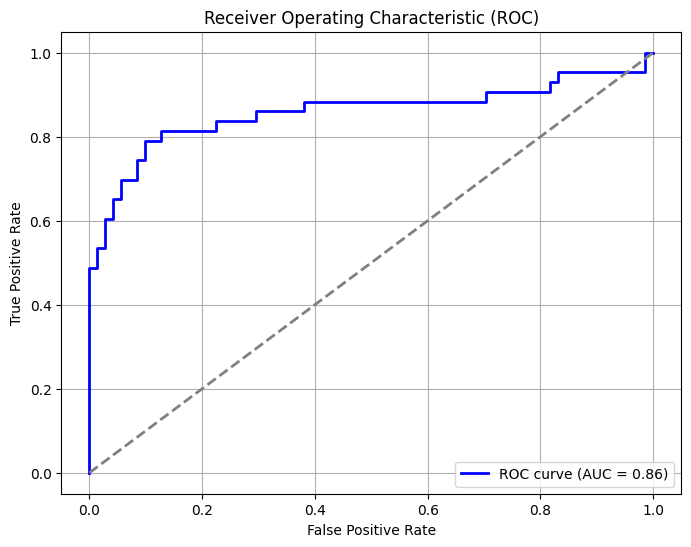

In [8]:
proba_dicts = model.predict_probability(X_test)
# positive = malignant
positive_probs = [p[1] for p in proba_dicts]
fpr, tpr, thresholds = roc_curve(y_test, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()